<a href="https://colab.research.google.com/github/slaninam/Loc1D/blob/master/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup and data import

## Environment setup

This is a view on the github-stored notebook. clone it first and navigate to a subfolder in orde to access the data files

In [1]:
! git clone https://github.com/slaninam/Loc1D.git

Cloning into 'Loc1D'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 96 (delta 3), reused 0 (delta 0), pack-reused 84
Unpacking objects: 100% (96/96), done.


In [2]:
cd Loc1D

/content/Loc1D


## Data preprocessing

All input files are read into a single pandas DataFrame.
The naming convention is maintained, one additional column 'dist' is added to record the actual distance at which the measurement was taken.

The complete preprocessed data is available in the DataFrame **df**


In [0]:
import pandas as pd
import numpy as np

dists = np.arange(0, 35.5, 0.5)
dfs = []
for dist in dists:
    if dist.is_integer():
        fname = 'data/dist.' + '{0:.0f}'.format(dist) + 'm.txt'
    else:
        fname = 'data/dist.' + '{0:.1f}'.format(dist) + 'm.txt'
    
    df = pd.read_csv(fname, header = None, names=['time','tag id','anchor id','anchor1 id', 'anchor2 id', 'anchor3 id','a0ch0','a0ch1','a0ch2','a0ch3','a0rssi0','a0rssi1','a0rssi2','a0rssi3','a1ch0','a1ch1','a1ch2','a1ch3','a1rssi0','a1rssi1','a1rssi2','a1rssi3','a2ch0','a2ch1','a2ch2','a2ch3','a2rssi0','a2rssi1','a2rssi2','a2rssi3','a3ch0','a3ch1','a3ch2','a3ch3','a3rssi0','a3rssi1','a3rssi2','a3rssi3'])
    df['dist'] = dist
    dfs.append(df)

df = pd.concat(dfs)

## Train and test set creation
The data is randomly divided in the train and test sets and the target values are put in separate vectors. 

Potentially leaky variables removed:
* 'time'

Othev variables removed as they contain no value:
* 'tag id'
* 'anchor id'
* 'anchor1 id'
* 'anchor2 id'
* 'anchor3 id'

In [0]:
from sklearn.model_selection import train_test_split

df = df.drop(axis=1,labels = ['time'])
df = df.drop(axis=1,labels = ['tag id','anchor id','anchor1 id','anchor2 id','anchor3 id'])

X_train, X_test, y_train, y_test = train_test_split(df.drop(axis=1,labels = ['dist']), df['dist'], test_size=0.3, random_state=0)


# Models



## ANN
* Multi-Layer Perceptron
* Totally random structure (first guess)
* Output F2-score 0.91 (=not bad)

In [0]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(40, 30), random_state=0)

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9531834869657286

## Classifier performance metrics

Plotting the predicted distances vs real distances:

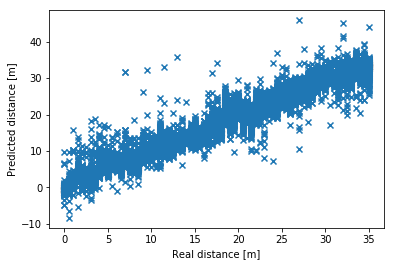

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

x = y_test
y = clf.predict(X_test)

plt.scatter(x,y,marker='x')
plt.xlabel('Real distance [m]')
plt.ylabel('Predicted distance [m]')
plt.show()

In [0]:
err = y-x
err.describe()

count    15091.000000
mean         0.025700
std          2.191961
min        -16.659808
25%         -1.176861
50%         -0.020850
75%          1.166256
max         24.798873
Name: dist, dtype: float64

In [0]:
srterr = sorted(abs(err))

In [0]:
srterr[13580]

3.2127221694425643

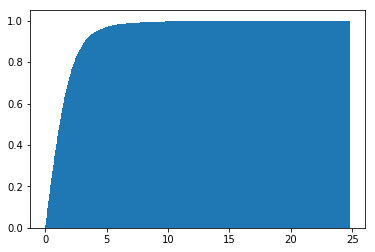

In [0]:
_=plt.hist(srterr, bins=1000, cumulative=True, density=True)

# PyTorch DNN


Train Epoch: 0 [0/35212 (0%)]	Loss: 522.138550
Train Epoch: 0 [2000/35212 (6%)]	Loss: 457.557190
Train Epoch: 0 [4000/35212 (11%)]	Loss: 59.171970
Train Epoch: 0 [6000/35212 (17%)]	Loss: 16.255747
Train Epoch: 0 [8000/35212 (23%)]	Loss: 3.369078
Train Epoch: 0 [10000/35212 (28%)]	Loss: 6.133544
Train Epoch: 0 [12000/35212 (34%)]	Loss: 2.487626
Train Epoch: 0 [14000/35212 (40%)]	Loss: 4.110135
Train Epoch: 0 [16000/35212 (45%)]	Loss: 2.314056
Train Epoch: 0 [18000/35212 (51%)]	Loss: 26.574442
Train Epoch: 0 [20000/35212 (57%)]	Loss: 7.470139
Train Epoch: 0 [22000/35212 (62%)]	Loss: 9.272501
Train Epoch: 0 [24000/35212 (68%)]	Loss: 8.124796
Train Epoch: 0 [26000/35212 (74%)]	Loss: 32.857899
Train Epoch: 0 [28000/35212 (80%)]	Loss: 8.274250
Train Epoch: 0 [30000/35212 (85%)]	Loss: 2.981504
Train Epoch: 0 [32000/35212 (91%)]	Loss: 3.720030
Train Epoch: 0 [34000/35212 (97%)]	Loss: 6.789320
Train Epoch: 1 [0/35212 (0%)]	Loss: 6.599244
Train Epoch: 1 [2000/35212 (6%)]	Loss: 2.660553
Train Epo

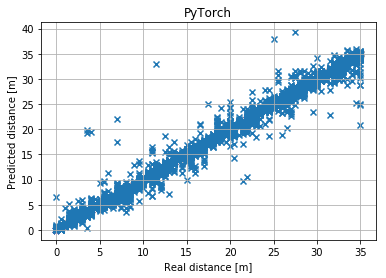

count    15091.000000
mean        -0.020108
std          0.657449
min        -14.217546
25%         -0.096015
50%         -0.016326
75%          0.060894
max         21.545506
dtype: float64


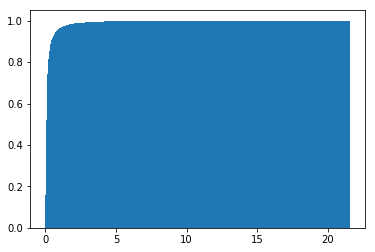

In [3]:
import numpy as np
import pandas as pd
import os

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin_1 = nn.Linear(16, 512)
        self.lin_2 = nn.Linear(self.lin_1.out_features, 256)
        self.lin_3 = nn.Linear(self.lin_2.out_features, 512)
        self.lin_4 = nn.Linear(self.lin_3.out_features, 256)
        self.lin_5 = nn.Linear(self.lin_4.out_features, 128)
        self.lin_6 = nn.Linear(self.lin_5.out_features, 64)
        self.lin_7 = nn.Linear(self.lin_6.out_features, 32)
        self.lin_8 = nn.Linear(self.lin_7.out_features, 1)

    def forward(self, x):
        x = F.relu(self.lin_1(x))
        x = F.relu(self.lin_2(x))
        x = F.relu(self.lin_3(x))
        x = F.relu(self.lin_4(x))
        x = F.relu(self.lin_5(x))
        x = F.relu(self.lin_6(x))
        x = F.relu(self.lin_7(x))
        x = F.relu(self.lin_8(x))
        return x


def main():
    dists = np.arange(0, 35.5, 0.5)
    dfs = []

    # Data loading
    for dist in dists:
        if dist.is_integer():
            fname = 'data/dist.' + '{0:.0f}'.format(dist) + 'm.txt'
        else:
            fname = 'data/dist.' + '{0:.1f}'.format(dist) + 'm.txt'
    
        df = pd.read_csv(fname, header = None, names=['time','tag id','anchor id','anchor1 id', 'anchor2 id', 'anchor3 id','a0ch0','a0ch1','a0ch2','a0ch3','a0rssi0','a0rssi1','a0rssi2','a0rssi3','a1ch0','a1ch1','a1ch2','a1ch3','a1rssi0','a1rssi1','a1rssi2','a1rssi3','a2ch0','a2ch1','a2ch2','a2ch3','a2rssi0','a2rssi1','a2rssi2','a2rssi3','a3ch0','a3ch1','a3ch2','a3ch3','a3rssi0','a3rssi1','a3rssi2','a3rssi3'])
        df['dist'] = dist
        dfs.append(df)

    df = pd.concat(dfs)
    df = df.drop(axis=1,labels = ['time'])
    df = df.drop(axis=1,labels = ['tag id','anchor id','anchor1 id','anchor2 id','anchor3 id', 'a0ch0','a0ch1','a0ch2','a0ch3', 'a1ch0','a1ch1','a1ch2','a1ch3', 'a2ch0','a2ch1','a2ch2','a2ch3', 'a3ch0','a3ch1','a3ch2','a3ch3'])

    # Data split
    X_train, X_test, y_train, y_test = train_test_split(df.drop(axis=1,labels = ['dist']), df['dist'], test_size=0.3, random_state=0)

    # Test and Train dataset preparations
    torch_X_train = torch.tensor(X_train.values, dtype=torch.float)
    torch_X_test = torch.tensor(X_test.values, dtype=torch.float)
    torch_Y_train = torch.tensor(y_train.values, dtype=torch.float)
    torch_Y_test = torch.tensor(y_test.values, dtype=torch.float)
    train_dataset = TensorDataset(torch_X_train, torch_Y_train)
    test_dataset = TensorDataset(torch_X_test, torch_Y_test)

    # Model training parameters
    model_path = "model.pth"
    batch_size=20
    learning_rate=0.0001
    epochs=100
    log_interval=100

    # Create instance of the network
    model = Net()

    # Create a Stochastic Gradient Descent optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Create a Mean Squared Error loss function
    criterion = nn.MSELoss()
    
    # Use CUDA if wanted and available in system (Don't, network is too small for benefits of GPU)
    use_cuda = False and torch.cuda.is_available()

    # Move model to GPU
    if use_cuda:
        model.cuda()

    train_loader = DataLoader(train_dataset, batch_size)
    test_loader = DataLoader(test_dataset)

    if not os.path.exists(model_path):
        # Set model to training mode
        model.train()
        # Run the main training loop
        for epoch in range(epochs):
            for batch_idx, (data, target) in enumerate(train_loader):
                # Resize data according to batch_size and last input batch_size
                target = target.view(data.shape[0], -1)

                if use_cuda:
                    data = data.cuda()
                    target = target.cuda()

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + Backward + Optimize
                net_out = model(data)

                if use_cuda:
                    net_out.cpu()

                loss = criterion(net_out, target)
                loss.backward()
                optimizer.step()

                # Print statistics
                if batch_idx % log_interval == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), 
                                                                                   len(train_loader.dataset), 
                                                                                   100. * batch_idx / len(train_loader), 
                                                                                   loss.item()))
        # Save the trained model
        torch.save(model.state_dict(), model_path)
    else:
        # Load the trained model
        model.load_state_dict(torch.load(model_path))

    # Set model to evaluation mode
    model.eval()

    x = list()
    y = list()
    # Run a test loop
    test_loss = 0
    with torch.no_grad():
        for id, (data, target) in enumerate(test_loader):
            # Resize data according to batch_size and last input batch_size
            target = target.view(data.shape[0], -1)
            net_out = model(data)
            # Sum up batch loss
            test_loss += criterion(net_out, target).item()
            # print("Expected/Predicted: {:.4f}/{:.4f}".format(target.item(), net_out.item()))
            x.append(target.item())
            y.append(net_out.item())

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

    # Plotting the predicted distances vs real distances:
    plt.scatter(x,y,marker='x')
    plt.title("PyTorch")
    plt.xlabel('Real distance [m]')
    plt.ylabel('Predicted distance [m]')
    plt.grid(True)
    plt.show()

    err = pd.Series(np.asarray(y) - np.asarray(x))
    print(err.describe())

    srterr = sorted(abs(err))

    plt.hist(srterr, bins=1000, cumulative=True, density=True)
    plt.show()


if __name__ == "__main__":
    main()
